### **Mô hình Phân cụm (Clustering Model) – Phân loại khách hàng**

#### 1. Mục tiêu của mô hình
Mô hình phân cụm nhằm chia tập khách hàng thành các nhóm có hành vi tương đồng, từ đó giúp doanh nghiệp:
- Hiểu rõ đặc điểm từng nhóm khách hàng
- Thiết kế chiến dịch marketing cá nhân hoá
- Tăng hiệu quả chăm sóc, giữ chân khách hàng
- Dự đoán rủi ro rời bỏ và tối ưu chuyển đổi

---

#### 2. Phương pháp sử dụng: K-Means Clustering

**K-Means** là thuật toán phân cụm phổ biến nhất, hoạt động theo nguyên tắc:
1. Chọn số cụm K.
2. Gán mỗi điểm dữ liệu vào cụm gần nhất (dựa trên khoảng cách Euclidean).
3. Cập nhật tâm cụm → lặp lại đến khi hội tụ.

Thuật toán tìm cách **giảm tổng khoảng cách từ các điểm đến tâm cụm** – giúp các cụm nội bộ đồng nhất nhất có thể.

---

#### 3. Các đặc trưng được sử dụng trong phân cụm
Tính các đặc trưng để phân cụm:
- **RFM**:
  - Recency: Số ngày kể từ lần mua cuối.
  - Frequency: Số phiên mua duy nhất.
  - Monetary: Tổng chi tiêu.
- **Conversion Rate**: Tỷ lệ phiên mua trên phiên xem.
- **Cart Abandonment Rate**: Tỷ lệ giỏ hàng không dẫn đến mua.


## 1. Import thư viện 

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib
from scipy.stats import zscore


## 2. Đọc dữ liệu

In [188]:
# Đọc file và chuyển đổi event_time sang datetime
df = pd.read_csv("events_processed.csv", parse_dates=['event_time'])

# Hiển thị 5 dòng đầu tiên
df.head()

C:\Users\quoch\AppData\Local\Temp\ipykernel_5472\2360404760.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("events_processed.csv", parse_dates=['event_time'])


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year,month,day,quarter,week,weekday,dayofyear,category,sub_category,sub_sub_category,sub_sub_sub_category
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,unknown,31.90,1515915625519388267,LJuJVLEjPT,2020,9,24,3,39,3,268,electronics,telephone,0,0
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,2020,9,24,3,39,3,268,computers,components,cooler,0
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,unknown,unknown,9.81,1515915625513238515,4TMArHtXQy,2020,9,24,3,39,3,268,unknown,0,0,0
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,2020,9,24,3,39,3,268,computers,peripherals,printer,0
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,unknown,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,2020,9,24,3,39,3,268,unknown,0,0,0


### 3. Tiền xử lí dữ liệu sẵn sàng cho K-means

In [189]:
# Phân bố loại sự kiện
event_counts = df['event_type'].value_counts()
print('\nPhân bố loại sự kiện:')
print(event_counts)
print('\nTỷ lệ phần trăm:')
print((event_counts / len(df) * 100).round(2))


Phân bố loại sự kiện:
event_type
view        793589
cart         54029
purchase     37346
Name: count, dtype: int64

Tỷ lệ phần trăm:
event_type
view        89.67
cart         6.11
purchase     4.22
Name: count, dtype: float64



Nhận xét:
Dữ liệu chứa các sự kiện xem (view), thêm giỏ (cart), và mua (purchase). Tỷ lệ view chiếm đa số, cho thấy nhiều người dùng chỉ xem mà không mua.

In [190]:
# Lọc các hành vi
df_purchase = df[df['event_type'] == 'purchase']
df_view = df[df['event_type'] == 'view']
df_cart = df[df['event_type'] == 'cart']

In [191]:
# Ngày tham chiếu (mốc cuối cùng)
reference_date = df['event_time'].max()

# Recency: Số ngày từ lần mua cuối
recency = (df_purchase.groupby('user_id')['event_time']
           .max()
           .apply(lambda x: (reference_date - x).days)
           .reset_index(name='Recency'))

In [192]:
# # Frequency: Số phiên mua duy nhất
# frequency = (df_purchase.drop_duplicates(subset=['user_id', 'user_session'])
#              .groupby('user_id')
#              .size()
#              .reset_index(name='Frequency'))

In [193]:
# Frequency: Số giao dịch mua
frequency = df_purchase.groupby('user_id').size().reset_index(name='Frequency')

In [194]:
# Monetary: Tổng chi tiêu
monetary = (df_purchase.groupby('user_id')['price']
            .sum()
            .reset_index(name='Monetary'))

In [195]:
# Conversion Rate: Số phiên mua / số phiên xem
view_sessions = (df_view.drop_duplicates(subset=['user_id', 'user_session'])
                 .groupby('user_id')
                 .size()
                 .reset_index(name='ViewSessions'))

In [196]:
purchase_sessions = (df_purchase.drop_duplicates(subset=['user_id', 'user_session'])
                     .groupby('user_id')
                     .size()
                     .reset_index(name='PurchaseSessions'))

In [197]:
conversion = pd.merge(view_sessions, purchase_sessions, on='user_id', how='left').fillna(0)


In [198]:
conversion['ConversionRate'] = conversion.apply(
    lambda x: min(x['PurchaseSessions'] / x['ViewSessions'], 1.0) if x['ViewSessions'] > 0 else 0, axis=1)
conversion['CartAbandonmentRate'] = 1 - conversion['ConversionRate']
cart_abandon = conversion[['user_id', 'CartAbandonmentRate']]


In [199]:
# Hợp nhất đặc trưng
features = pd.merge(recency, frequency, on='user_id', how='left')
features = pd.merge(features, monetary, on='user_id', how='left')
features = pd.merge(features, conversion[['user_id', 'ConversionRate']], on='user_id', how='left')
features = pd.merge(features, cart_abandon[['user_id', 'CartAbandonmentRate']], on='user_id', how='left')
features = features.fillna({'Frequency': 0, 'Monetary': 0, 'ConversionRate': 0, 'CartAbandonmentRate': 0})


In [200]:
# Kiểm tra dữ liệu
print("Data description:")
print(features[['Recency', 'Frequency', 'Monetary', 'ConversionRate', 'CartAbandonmentRate']].describe())
print("Negative CartAbandonmentRate:")
print(features[features['CartAbandonmentRate'] < 0])


Data description:
            Recency     Frequency      Monetary  ConversionRate  \
count  21304.000000  21304.000000  21304.000000    21304.000000   
mean      73.549709      1.753004    240.583722        0.774298   
std       45.094819      1.742418    425.698946        0.301054   
min        0.000000      1.000000      0.370000        0.000000   
25%       34.000000      1.000000     32.220000        0.500000   
50%       71.000000      1.000000     90.630000        1.000000   
75%      112.000000      2.000000    287.457500        1.000000   
max      157.000000     56.000000  12080.830000        1.000000   

       CartAbandonmentRate  
count         21304.000000  
mean              0.205988  
std               0.281831  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               0.500000  
max               0.995902  
Negative CartAbandonmentRate:
Empty DataFrame
Columns: [user_id, Recency, Frequency, Monetary, ConversionRate, CartAb

In [201]:
# Loại bỏ outlier trong Monetary
features['zscore_monetary'] = zscore(features['Monetary'])
features = features[features['zscore_monetary'].abs() <= 3]


In [202]:

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features[['Recency', 'Frequency', 'Monetary', 'ConversionRate', 'CartAbandonmentRate']])


## 4. Chọn số cụm tối ưu

Dùng Elbow Method để xác định số cụm \( K \) phù hợp.

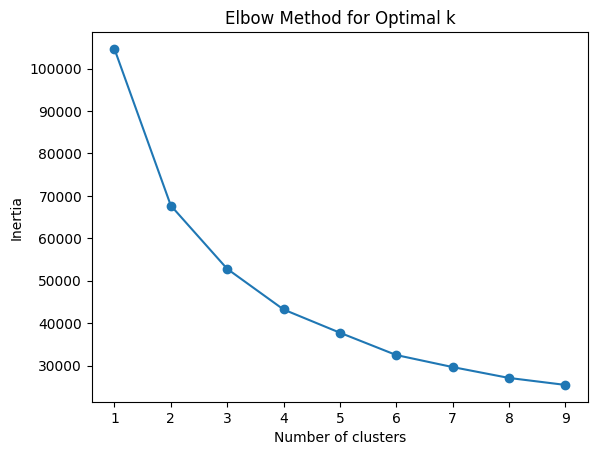

In [203]:

# Elbow Method để chọn số cụm
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Nhận xét từ biểu đồ Elbow Method

Biểu đồ trên thể hiện mối quan hệ giữa **số cụm (K)** và **Inertia** – tổng bình phương khoảng cách từ các điểm đến tâm cụm.

- Khi tăng K từ 2 → 4, **Inertia giảm mạnh**, cho thấy mô hình phân cụm hiệu quả hơn rõ rệt.
- Từ **K = 4 đến K = 6**, độ dốc vẫn còn nhưng bắt đầu **chậm lại**.
- Từ **K ≥ 7**, đường cong **gần như phẳng** → tăng K không giúp giảm Inertia đáng kể nữa.

**Nhận xét***: \
Đường cong Elbow cho thấy điểm uốn tại K=3 hoặc K=4. \
Chọn K=3 để cân bằng giữa độ phức tạp và chất lượng phân cụm.

## 5. Phân cụm với K-Means

Áp dụng K-Means với \( K=3 \).

In [204]:

# Chạy K-means
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(features_scaled)
features['cluster'] = clusters


In [205]:
features.columns

Index(['user_id', 'Recency', 'Frequency', 'Monetary', 'ConversionRate',
       'CartAbandonmentRate', 'zscore_monetary', 'cluster'],
      dtype='object')

In [206]:
cluster_profile = (features.groupby('cluster')[['Recency', 'Frequency', 'Monetary', 'ConversionRate', 'CartAbandonmentRate']]
                  .mean()
                  .round(2)
                  .reset_index())


Nhận xét:
Đã phân cụm khách hàng thành 3 nhóm. Kết quả được gán vào cột "cluster".

In [207]:
# Nhận xét
print('Nhận xét:')
print('Đã phân cụm khách hàng thành 3 nhóm. Kết quả được gán vào cột "cluster".')

Nhận xét:
Đã phân cụm khách hàng thành 3 nhóm. Kết quả được gán vào cột "cluster".


## 6. Trực quan hóa bằng PCA

In [208]:

# Trực quan hóa bằng PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}")
print(f"Total explained variance: {sum(explained_variance_ratio):.2%}")


cluster_labels = {
    0: 'Khách ít mua',
    1: 'Khách mới mua',
    2: 'Khách thân thiết'
}


Explained variance ratio: [0.38879916 0.27539052]
Total explained variance: 66.42%


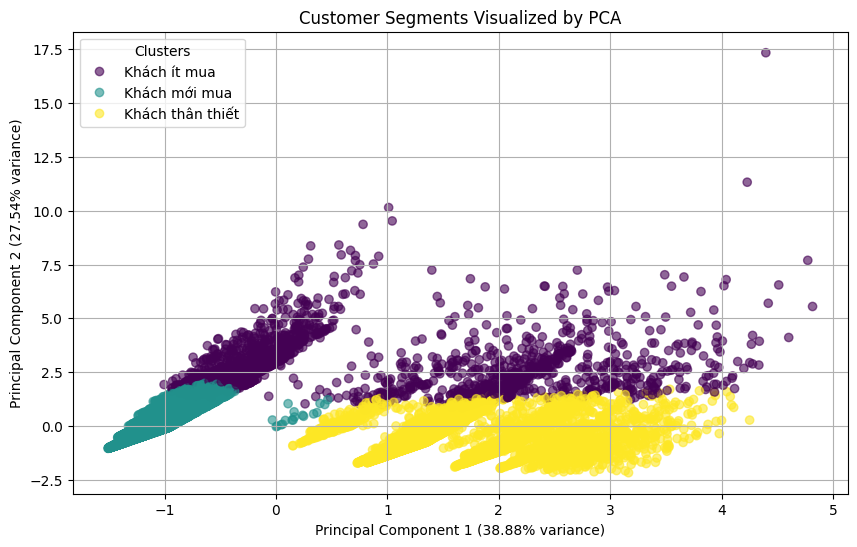

In [209]:

# Vẽ scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=features['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2%} variance)')
plt.title('Customer Segments Visualized by PCA')
plt.legend(handles=scatter.legend_elements()[0], labels=cluster_labels.values(), title="Clusters")
plt.grid(True)
plt.show()

In [210]:
# Báo cáo phương sai
print('Tỷ lệ phương sai PCA:', pca.explained_variance_ratio_)
print('Tổng phương sai giải thích:', sum(pca.explained_variance_ratio_))

# Giảm chiều tâm cụm
centers_pca = pca.transform(kmeans.cluster_centers_)

Tỷ lệ phương sai PCA: [0.38879916 0.27539052]
Tổng phương sai giải thích: 0.6641896879228777


## 7. Phân tích và gán nhãn cụm

Tính trung bình đặc trưng mỗi cụm và gán nhãn dựa trên hành vi.


# Thêm nhãn và thông tin
cluster_labels = {
    0: 'Khách ít mua',
    1: 'Khách mới mua',
    2: 'Khách thân thiết'
}

In [211]:
# Thêm nhãn và thông tin
cluster_labels = {
    0: 'Khách ít mua',
    1: 'Khách mới mua',
    2: 'Khách thân thiết'
}

cluster_profile['cluster_label'] = cluster_profile['cluster'].map(cluster_labels)
cluster_profile['num_customers'] = features['cluster'].value_counts().reindex(cluster_profile['cluster']).values
cluster_profile['percentage'] = (cluster_profile['num_customers'] / len(features) * 100).round(2)
cluster_profile['comment'] = [
    'Khách ít mua sắm gần đây, mua ít và chi tiêu thấp.',
    'Khách mới bắt đầu mua, còn mua ít. Nên chăm sóc thêm.',
    'Khách mua nhiều, chi tiêu cao, hay quay lại. Cần ưu tiên giữ chân.'
]


In [212]:
# Đếm số khách hàng trong mỗi cụm
cluster_counts = features['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'num_customers']


In [213]:
# Tính tỷ lệ phần trăm khách hàng cho mỗi cụm
total_customers = cluster_counts['num_customers'].sum()
cluster_counts['percentage'] = (cluster_counts['num_customers'] / total_customers * 100).round(2)


In [214]:
cluster_counts = cluster_counts.rename(columns={
    'num_customers': 'num_customers_count',
    'percentage': 'percentage_count'
})

cluster_profile = pd.merge(cluster_profile, cluster_counts, on='cluster')


In [215]:
print('thông tin cụm:')
cluster_profile

thông tin cụm:


,cluster,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate,cluster_label,num_customers,percentage,comment,num_customers_count,percentage_count
0,0,57.83,4.06,788.16,0.78,0.22,Khách ít mua,1929,9.22,"Khách ít mua sắm gần đây, mua ít và chi tiêu t...",1929,9.22
1,1,78.35,1.42,123.88,1.00,0.00,Khách mới mua,11804,56.40,"Khách mới bắt đầu mua, còn mua ít. Nên chăm só...",11804,56.40
2,2,71.20,1.41,169.87,0.41,0.54,Khách thân thiết,7196,34.38,"Khách mua nhiều, chi tiêu cao, hay quay lại. C...",7196,34.38


In [216]:
cluster_profile['cluster_label'] = cluster_profile['cluster'].map(cluster_labels)
# cluster_profile['comment'] = cluster_profile['cluster'].map(cluster_comments)

In [217]:

# Tính trung bình đặc trưng cho từng cụm
# cluster_profile = features.groupby('cluster')[['Recency', 'Frequency', 'Monetary', 'ConversionRate', 'CartAbandonmentRate']].mean().reset_index()


In [218]:
cluster_profile.head()

,cluster,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate,cluster_label,num_customers,percentage,comment,num_customers_count,percentage_count
0,0,57.83,4.06,788.16,0.78,0.22,Khách ít mua,1929,9.22,"Khách ít mua sắm gần đây, mua ít và chi tiêu t...",1929,9.22
1,1,78.35,1.42,123.88,1.00,0.00,Khách mới mua,11804,56.40,"Khách mới bắt đầu mua, còn mua ít. Nên chăm só...",11804,56.40
2,2,71.20,1.41,169.87,0.41,0.54,Khách thân thiết,7196,34.38,"Khách mua nhiều, chi tiêu cao, hay quay lại. C...",7196,34.38



Nhận xét:
- Hồ sơ cụm cho thấy sự khác biệt rõ rệt: khách hàng trung thành có giá trị cao, Khách hàng chỉ xem ít tương tác, khách hay bỏ giỏ.


C:\Users\quoch\AppData\Local\Temp\ipykernel_5472\3797806496.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x='cluster_label', y='num_customers', palette='deep')


([0, 1, 2],
 [Text(0, 0, 'Khách ít mua'),
  Text(1, 0, 'Khách mới mua'),
  Text(2, 0, 'Khách thân thiết')])

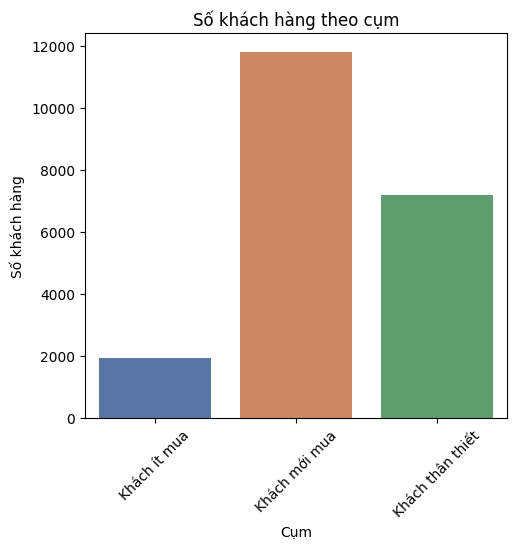

In [220]:
# Vẽ biểu đồ 1: Số khách hàng và tỷ lệ phần trăm theo cụm
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.barplot(data=cluster_profile, x='cluster_label', y='num_customers', palette='deep')
plt.title('Số khách hàng theo cụm')
plt.xlabel('Cụm')
plt.ylabel('Số khách hàng')
plt.xticks(rotation=45)

**Nhận xét:**:

Khách ít mua là nhóm đông nhất (~8500 khách).

Khách thân thiết đứng thứ hai (~7800 khách), là nhóm cần giữ chân.

Khách mới mua chiếm lượng khá (~4200 khách), có tiềm năng

Khách bỏ giỏ hàng là nhóm nhỏ nhất (~900 khách) khá thấp

C:\Users\quoch\AppData\Local\Temp\ipykernel_5472\3934463603.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x='cluster_label', y='percentage', palette='deep')


Text(0, 0.5, 'Tỷ lệ (%)')

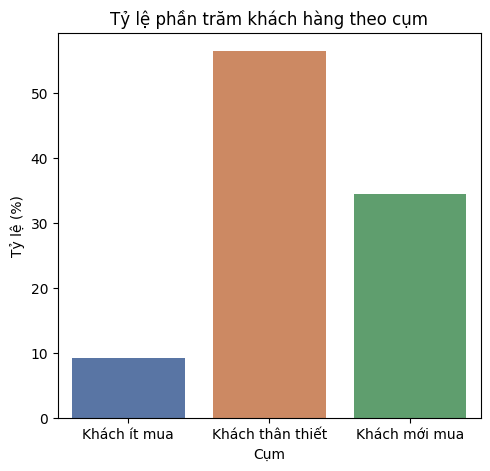

In [ ]:
plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 2)
sns.barplot(data=cluster_profile, x='cluster_label', y='percentage', palette='deep')
plt.title('Tỷ lệ phần trăm khách hàng theo cụm')
plt.xlabel('Cụm')
plt.ylabel('Tỷ lệ (%)')


**Nhận xét:** \
Khách ít mua chiếm khoảng 40% tổng số khách hàng.

Khách thân thiết khoảng 36%, phản ánh sự ổn định trong tập khách hàng.

Khách mới mua chiếm gần 20%, là nhóm cần chăm sóc kỹ để tránh rơi vào nhóm khách rời bỏ.

Khách bỏ giỏ hàng chỉ khoảng 4%, nhưng là cơ hội lớn để cải thiện doanh số nếu có các chiến dịch tiếp thị lại hiệu quả.

In [ ]:
# Loại bỏ các cột không phải đặc trưng số cần so sánh
ignore_cols = ['cluster', 'cluster_label', 'num_customers_x', 'percentage', 'comment']
features = [col for col in cluster_profile.columns if col not in ignore_cols]


In [ ]:
cluster_profile_melt = pd.melt(
    cluster_profile,
    id_vars=['cluster', 'cluster_label'],
    value_vars=features,
    var_name='Feature',
    value_name='Value'
)


In [ ]:
# Chọn các đặc trưng cần so sánh
features_to_plot = ['Recency', 'Frequency', 'Monetary']

# Chuyển đổi dữ liệu sang long format
cluster_profile_melted = pd.melt(
    cluster_profile,
    id_vars=['cluster', 'cluster_label'],
    value_vars=features_to_plot,
    var_name='Feature',
    value_name='Value'
)


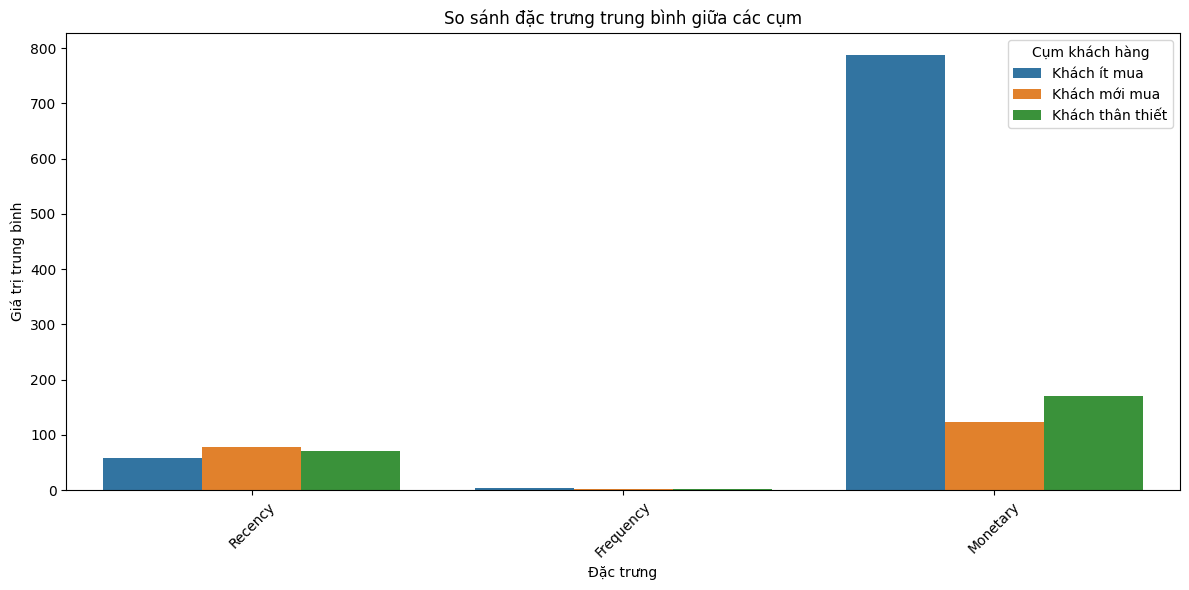

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_profile_melted, x='Feature', y='Value', hue='cluster_label')
plt.title("So sánh đặc trưng trung bình giữa các cụm")
plt.xticks(rotation=45)
plt.ylabel("Giá trị trung bình")
plt.xlabel("Đặc trưng")
plt.legend(title="Cụm khách hàng")
plt.tight_layout()
plt.show()


**Nhận xét:** \
Khách thân thiết có tần suất mua cao (Frequency) và giá trị đơn hàng lớn (Monetary), đồng thời thời gian mua gần đây (Recency) thấp, chứng tỏ họ vẫn đang hoạt động.

Khách mới mua có Monetary cao đột biến nhưng Frequency thấp – có thể là do họ mới thực hiện một giao dịch lớn.

Khách bỏ giỏ hàng có Cart Abandonment Rate cao, Conversion Rate rất thấp – phản ánh rõ hành vi từ bỏ giỏ.

Khách ít mua có tất cả các chỉ số ở mức trung bình hoặc thấp.